# Final Project

In [315]:
'''Breast cancer survival data from the TCGA holds clues as to what genetic mutations may cause the 
ultimate fate of patients. In this study, we perform standard survival analysis using  Kaplan Meir Fitter Survival and 
COX Partial Hazards, and finally use a gradient boosting model to see if we can predict survival of a patient based on 
their mutations.'''


#You can find the clinical file of breast cancer patients in the data folder. This file contains patient case ids, 
#information about their ultimate vital status, duration of cancer information, and races.Let's load this information
#into a pandas dataset.
import numpy as np
import pandas as pd

clinical_file = 'clinical.tsv'
df = pd.read_csv(clinical_file, sep='\t')
df.head()

,case_id,submitter_id,project_id,gender,year_of_birth,race,days_to_birth,vital_status,days_to_death,ethnicity,year_of_death,ann_arbor_b_symptoms,year_of_diagnosis,classification_of_tumor,last_known_disease_status,method_of_diagnosis,laterality,residual_disease,primary_diagnosis,tumor_stage,age_at_diagnosis,hpv_positive_type,morphology,ann_arbor_clinical_stage,new_event_anatomic_site,days_to_last_known_disease_status,perineural_invasion_present,ajcc_clinical_n,prior_treatment,ajcc_clinical_m,colon_polyps_history,ajcc_pathologic_m,ajcc_pathologic_n,ldh_level_at_diagnosis,days_to_last_follow_up,ann_arbor_pathologic_stage,days_to_recurrence,tumor_grade,figo_stage,cause_of_death,lymphatic_invasion_present,tissue_or_organ_of_origin,progression_or_recurrence,ajcc_clinical_t,hpv_status,prior_malignancy,vascular_invasion_present,new_event_type,ajcc_pathologic_stage,burkitt_lymphoma_clinical_variant,circumferential_resection_margin,ldh_normal_range_upper,ann_arbor_extranodal_involvement,lymph_nodes_positive,site_of_resection_or_biopsy,ajcc_pathologic_t,days_to_hiv_diagnosis,ajcc_clinical_stage,days_to_new_event,hiv_positive
0,3927f736-3b5c-48c8-9d9e-83669ec44770,TCGA-A8-A09G,TCGA-BRCA,female,1929,not reported,-29006,alive,--,not reported,--,--,--,not reported,not reported,--,--,--,"Infiltrating duct carcinoma, NOS",stage iiic,29006,--,8500/3,--,--,--,--,--,--,--,--,--,--,--,0,--,--,not reported,--,--,--,"Breast, NOS",not reported,--,--,not reported,--,--,--,--,--,--,--,--,"Breast, NOS",--,--,--,--,--
1,03c143e0-d8a1-4d60-a4a3-df0501fc6b6e,TCGA-E9-A1N3,TCGA-BRCA,female,1940,white,-25714,alive,--,not hispanic or latino,--,--,--,not reported,not reported,--,--,--,Infiltrating duct and lobular carcinoma,stage iiia,25714,--,8522/3,--,--,--,--,--,--,--,--,--,--,--,1059,--,--,not reported,--,--,--,"Breast, NOS",not reported,--,--,not reported,--,--,--,--,--,--,--,--,"Breast, NOS",--,--,--,--,--
2,2fe854b4-bac9-4801-9a1c-ee99388e8082,TCGA-AO-A12D,TCGA-BRCA,female,1962,white,-15774,alive,--,not hispanic or latino,--,--,--,not reported,not reported,--,--,--,"Infiltrating duct carcinoma, NOS",stage iia,15774,--,8500/3,--,--,--,--,--,--,--,--,--,--,--,2515,--,--,not reported,--,--,--,"Breast, NOS",not reported,--,--,not reported,--,--,--,--,--,--,--,--,"Breast, NOS",--,--,--,--,--
3,8218119a-f68b-4ea7-9ee4-5e2edc2ae342,TCGA-E9-A245,TCGA-BRCA,female,1964,white,-17363,dead,--,not hispanic or latino,--,--,--,not reported,not reported,--,--,--,"Infiltrating duct carcinoma, NOS",stage iib,17363,--,8500/3,--,--,--,--,--,--,--,--,--,--,--,26,--,--,not reported,--,--,--,"Breast, NOS",not reported,--,--,not reported,--,--,--,--,--,--,--,--,"Breast, NOS",--,--,--,--,--
4,5e670fec-8992-44bf-8657-f7f9a272306b,TCGA-A2-A0EN,TCGA-BRCA,female,1933,white,-25771,alive,--,not hispanic or latino,--,--,--,not reported,not reported,--,--,--,"Lobular carcinoma, NOS",stage iia,25771,--,8520/3,--,--,--,--,--,--,--,--,--,--,--,2718,--,--,not reported,--,--,--,"Breast, NOS",not reported,--,--,not reported,--,--,--,--,--,--,--,--,"Breast, NOS",--,--,--,--,--


In [316]:
#This dataset alone doesn't tell us anything about the actual mutation data of each case/patient. That is found 
#sperately in the maf file in the data folder.

#Download TCGA Breast Cancer data with Mutation data
#Change the filename parameter to where you download the maf.gz file
maf_file = "TCGA.BRCA.mutect.995c0111-d90b-4140-bee7-3845436c3b42.DR-10.0.somatic.maf.gz"
pd.set_option('display.max_columns', None)
maf = pd.read_table(maf_file, comment='#')

#Filter the mutation data to get the most prevelant mutations
mut = maf[(maf.FILTER == "PASS") & ((maf.IMPACT == "MODERATE") | (maf.IMPACT == "HIGH"))]

print("{} out of {} mutations passed the filtering criteria, {:.2f}%".format(
    len(mut), len(maf), 100 * len(mut) / len(maf)))

#Let's load the mutation data.
#You will notice that each mutated gene is under the Hugo_Symbol column and can also be referred to by the Entrez_Gene_Id
mut.head()

C:\Users\wr225\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (87,88,118) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


73156 out of 120988 mutations passed the filtering criteria, 60.47%


,Hugo_Symbol,Entrez_Gene_Id,Center,NCBI_Build,Chromosome,Start_Position,End_Position,Strand,Variant_Classification,Variant_Type,Reference_Allele,Tumor_Seq_Allele1,Tumor_Seq_Allele2,dbSNP_RS,dbSNP_Val_Status,Tumor_Sample_Barcode,Matched_Norm_Sample_Barcode,Match_Norm_Seq_Allele1,Match_Norm_Seq_Allele2,Tumor_Validation_Allele1,Tumor_Validation_Allele2,Match_Norm_Validation_Allele1,Match_Norm_Validation_Allele2,Verification_Status,Validation_Status,Mutation_Status,Sequencing_Phase,Sequence_Source,Validation_Method,Score,BAM_File,Sequencer,Tumor_Sample_UUID,Matched_Norm_Sample_UUID,HGVSc,HGVSp,HGVSp_Short,Transcript_ID,Exon_Number,t_depth,t_ref_count,t_alt_count,n_depth,n_ref_count,n_alt_count,all_effects,Allele,Gene,Feature,Feature_type,One_Consequence,Consequence,cDNA_position,CDS_position,Protein_position,Amino_acids,Codons,Existing_variation,ALLELE_NUM,DISTANCE,TRANSCRIPT_STRAND,SYMBOL,SYMBOL_SOURCE,HGNC_ID,BIOTYPE,CANONICAL,CCDS,ENSP,SWISSPROT,TREMBL,UNIPARC,RefSeq,SIFT,PolyPhen,EXON,INTRON,DOMAINS,GMAF,AFR_MAF,AMR_MAF,ASN_MAF,EAS_MAF,EUR_MAF,SAS_MAF,AA_MAF,EA_MAF,CLIN_SIG,SOMATIC,PUBMED,MOTIF_NAME,MOTIF_POS,HIGH_INF_POS,MOTIF_SCORE_CHANGE,IMPACT,PICK,VARIANT_CLASS,TSL,HGVS_OFFSET,PHENO,MINIMISED,ExAC_AF,ExAC_AF_Adj,ExAC_AF_AFR,ExAC_AF_AMR,ExAC_AF_EAS,ExAC_AF_FIN,ExAC_AF_NFE,ExAC_AF_OTH,ExAC_AF_SAS,GENE_PHENO,FILTER,CONTEXT,src_vcf_id,tumor_bam_uuid,normal_bam_uuid,case_id,GDC_FILTER,COSMIC,MC3_Overlap,GDC_Validation_Status
1,ERICH3,127254,WUGSC,GRCh38,chr1,74571494,74571494,+,Missense_Mutation,SNP,C,C,T,NaN,NaN,TCGA-D8-A1XY-01A-11D-A14K-09,TCGA-D8-A1XY-10A-01D-A14K-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Somatic,NaN,NaN,NaN,NaN,NaN,Illumina HiSeq 2000,edb6d161-8f50-4c11-8246-487c4ea9a55d,8dea96d9-5017-4872-a84e-33bfd2f37b7a,c.4216G>A,p.Glu1406Lys,p.E1406K,ENST00000326665,14/15,86,42,44,64,NaN,NaN,"ERICH3,missense_variant,p.E1406K,ENST000003266...",T,ENSG00000178965,ENST00000326665,Transcript,missense_variant,missense_variant,4435/7159,4216/4593,1406/1530,E/K,Gag/Aag,NaN,1,NaN,-1.0,ERICH3,HGNC,HGNC:25346,protein_coding,YES,CCDS30755.1,ENSP00000322609,Q5RHP9,NaN,UPI0000237200,NM_001002912.4,deleterious(0.01),possibly_damaging(0.833),14/15,NaN,PROSITE_profiles:PS50313,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MODERATE,1.0,SNV,5.0,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PASS,TTCCTCTACCA,d083d669-6646-463b-853e-c58da8d06439,4374e19d-c5e7-49cf-8707-05ae5aeb7369,aadee87c-6a68-4580-bd10-64ac273b1e3d,0130d616-885e-4a6c-9d03-2f17dd692a05,NaN,COSM1474194,True,Unknown
6,FN1,2335,WUGSC,GRCh38,chr2,215397809,215397809,+,Nonsense_Mutation,SNP,C,C,A,NaN,NaN,TCGA-D8-A1XY-01A-11D-A14K-09,TCGA-D8-A1XY-10A-01D-A14K-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Somatic,NaN,NaN,NaN,NaN,NaN,Illumina HiSeq 2000,edb6d161-8f50-4c11-8246-487c4ea9a55d,8dea96d9-5017-4872-a84e-33bfd2f37b7a,c.3388G>T,p.Glu1130Ter,p.E1130*,ENST00000359671,22/45,94,77,17,106,NaN,NaN,"FN1,stop_gained,p.E1130*,ENST00000354785,NM_21...",A,ENSG00000115414,ENST00000359671,Transcript,stop_gained,stop_gained,3654/8524,3388/7161,1130/2386,E/*,Gaa/Taa,NaN,1,NaN,-1.0,FN1,HGNC,HGNC:3778,protein_coding,NaN,NaN,ENSP00000352696,P02751,NaN,UPI00001AEBF3,NaN,NaN,NaN,22/45,NaN,Pfam_domain:PF00041;PROSITE_profiles:PS50853;S...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HIGH,NaN,SNV,5.0,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PASS,CACTTCTCGTG,d083d669-6646-463b-853e-c58da8d06439,4374e19d-c5e7-49cf-8707-05ae5aeb7369,aadee87c-6a68-4580-bd10-64ac273b1e3d,0130d616-885e-4a6c-9d03-2f17dd692a05,NaN,COSM1482746;COSM1482747,True,Unknown
7,SPHKAP,80309,WUGSC,GRCh38,chr2,228016738,228016738,+,Missense_Mutation,SNP,C,C,A,NaN,NaN,TCGA-D8-A1XY-01A-11D-A14K-09,TCGA-D8-A1XY-10A-01D-A14K-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Somatic,NaN,NaN,NaN,NaN,NaN,Illumina HiSeq 2000,edb6d161-8f50-4c11-8246-487c4ea9a55d,8dea96d9-5017-4872-a84e-33bfd2f37b7a,c.4116G>T,p.Arg1372Ser,p.R1372S,ENST00000392056,7/12,74,61,13,61,NaN,NaN,"SPHKAP,missense_variant,p.R1372S,ENST000003920...

In [317]:
#Not every single mutated gene is important here. Since, we are dealing with breast cancer, we should really focus on 
#the TP53 and PIK3CA genes. We can find the mutation load of each gene and we will see that the TP53 and PIK3CA gene
#have the highest load.
mutation_frequency = mut.groupby("Hugo_Symbol")["Tumor_Sample_Barcode"].nunique().reset_index()
mutation_frequency.sort_values("Tumor_Sample_Barcode", ascending=False, inplace=True)
mutation_frequency.head(10)

,Hugo_Symbol,Tumor_Sample_Barcode
14207,TP53,325
10175,PIK3CA,323
14595,TTN,184
2338,CDH1,132
5145,GATA3,129
8415,MUC16,111
7076,KMT2C,90
7760,MAP3K1,79
11836,RYR2,63
5967,HMCN1,61


In [318]:
#Let's take parts of the mutation set that are most relevant going forward. Let's store it in a new dataframe called relmut
relmut = mut[['Hugo_Symbol', 'Entrez_Gene_Id', 'case_id', 'Tumor_Sample_Barcode']]
relmut.head()

,Hugo_Symbol,Entrez_Gene_Id,case_id,Tumor_Sample_Barcode
1,ERICH3,127254,0130d616-885e-4a6c-9d03-2f17dd692a05,TCGA-D8-A1XY-01A-11D-A14K-09
6,FN1,2335,0130d616-885e-4a6c-9d03-2f17dd692a05,TCGA-D8-A1XY-01A-11D-A14K-09
7,SPHKAP,80309,0130d616-885e-4a6c-9d03-2f17dd692a05,TCGA-D8-A1XY-01A-11D-A14K-09
8,HRH1,3269,0130d616-885e-4a6c-9d03-2f17dd692a05,TCGA-D8-A1XY-01A-11D-A14K-09
11,PIK3CA,5290,0130d616-885e-4a6c-9d03-2f17dd692a05,TCGA-D8-A1XY-01A-11D-A14K-09


In [319]:
#You will notice that there are case ids in this mutation file. These case ids correspond to the case ids in our clinical file.
#We want to find the instances in our clinical file that are also part of the mutation file.
cID = relmut.case_id.tolist() #let's store the case ids inside a list
df = df[df['case_id'].isin(cID)] #Now let's filter our clinical file dataframe with the case ids also in relmut
df.head(10)

,case_id,submitter_id,project_id,gender,year_of_birth,race,days_to_birth,vital_status,days_to_death,ethnicity,year_of_death,ann_arbor_b_symptoms,year_of_diagnosis,classification_of_tumor,last_known_disease_status,method_of_diagnosis,laterality,residual_disease,primary_diagnosis,tumor_stage,age_at_diagnosis,hpv_positive_type,morphology,ann_arbor_clinical_stage,new_event_anatomic_site,days_to_last_known_disease_status,perineural_invasion_present,ajcc_clinical_n,prior_treatment,ajcc_clinical_m,colon_polyps_history,ajcc_pathologic_m,ajcc_pathologic_n,ldh_level_at_diagnosis,days_to_last_follow_up,ann_arbor_pathologic_stage,days_to_recurrence,tumor_grade,figo_stage,cause_of_death,lymphatic_invasion_present,tissue_or_organ_of_origin,progression_or_recurrence,ajcc_clinical_t,hpv_status,prior_malignancy,vascular_invasion_present,new_event_type,ajcc_pathologic_stage,burkitt_lymphoma_clinical_variant,circumferential_resection_margin,ldh_normal_range_upper,ann_arbor_extranodal_involvement,lymph_nodes_positive,site_of_resection_or_biopsy,ajcc_pathologic_t,days_to_hiv_diagnosis,ajcc_clinical_stage,days_to_new_event,hiv_positive
0,3927f736-3b5c-48c8-9d9e-83669ec44770,TCGA-A8-A09G,TCGA-BRCA,female,1929,not reported,-29006,alive,--,not reported,--,--,--,not reported,not reported,--,--,--,"Infiltrating duct carcinoma, NOS",stage iiic,29006,--,8500/3,--,--,--,--,--,--,--,--,--,--,--,0,--,--,not reported,--,--,--,"Breast, NOS",not reported,--,--,not reported,--,--,--,--,--,--,--,--,"Breast, NOS",--,--,--,--,--
1,03c143e0-d8a1-4d60-a4a3-df0501fc6b6e,TCGA-E9-A1N3,TCGA-BRCA,female,1940,white,-25714,alive,--,not hispanic or latino,--,--,--,not reported,not reported,--,--,--,Infiltrating duct and lobular carcinoma,stage iiia,25714,--,8522/3,--,--,--,--,--,--,--,--,--,--,--,1059,--,--,not reported,--,--,--,"Breast, NOS",not reported,--,--,not reported,--,--,--,--,--,--,--,--,"Breast, NOS",--,--,--,--,--
2,2fe854b4-bac9-4801-9a1c-ee99388e8082,TCGA-AO-A12D,TCGA-BRCA,female,1962,white,-15774,alive,--,not hispanic or latino,--,--,--,not reported,not reported,--,--,--,"Infiltrating duct carcinoma, NOS",stage iia,15774,--,8500/3,--,--,--,--,--,--,--,--,--,--,--,2515,--,--,not reported,--,--,--,"Breast, NOS",not reported,--,--,not reported,--,--,--,--,--,--,--,--,"Breast, NOS",--,--,--,--,--
3,8218119a-f68b-4ea7-9ee4-5e2edc2ae342,TCGA-E9-A245,TCGA-BRCA,female,1964,white,-17363,dead,--,not hispanic or latino,--,--,--,not reported,not reported,--,--,--,"Infiltrating duct carcinoma, NOS",stage iib,17363,--,8500/3,--,--,--,--,--,--,--,--,--,--,--,26,--,--,not reported,--,--,--,"Breast, NOS",not reported,--,--,not reported,--,--,--,--,--,--,--,--,"Breast, NOS",--,--,--,--,--
4,5e670fec-8992-44bf-8657-f7f9a272306b,TCGA-A2-A0EN,TCGA-BRCA,female,1933,white,-25771,alive,--,not hispanic or latino,--,--,--,not reported,not reported,--,--,--,"Lobular carcinoma, NOS",stage iia,25771,--,8520/3,--,--,--,--,--,--,--,--,--,--,--,2718,--,--,not reported,--,--,--,"Breast, NOS",not reported,--,--,not reported,--,--,--,--,--,--,--,--,"Breast, NOS",--,--,--,--,--
5,1cc30842-4a5b-4f07-b36f-5b84ceaa5662,TCGA-BH-A8FZ,TCGA-BRCA,female,1954,white,-21343,alive,--,not hispanic or latino,--,--,--,not reported,not reported,--,--,--,"Lobular carcinoma, NOS",stage ia,21343,--,8520/3,--,--,--,--,--,--,--,--,--,--,--,574,--,--,not reported,--,--,--,"Breast, NOS",not reported,--,--,not reported,--,--,--,--,--,--,--,--,"Breast, NOS",--,--,--,--,--
6,7eb18190-5a41-4637-9783-f81bbde499e4,TCGA-BH-A1FM,TCGA-BRCA,female,1954,white,-16289,dead,1388,not hispanic or latino,2001,--,--,not reported,not reported,--,--,--,"Infiltrating duct carcinoma, NOS",stage iiia,16289,--,8500/3,--,--,--,--,--,--,--,--,--,--,--,--,--,--,not reported,--,--,--,"Breast, NOS",not reported,--,--,not reported,--,--,--,--,--,--,--,--,"Breast, NOS",--,--,--,--,--
7,4d120899-9a80-4736-b097-285e9e261bcb,TCGA-AQ-A1H2,TCGA-BRCA,female,1926,white,-30958,alive,--,not hispanic or latino,--,--,--,not reported,not reported,--,--,--,"Inf

In [320]:
#As shown in the pandas dataframe for the clinical file, we have multiple fields of information for each patient sample. 
#However, we are particularly interested in the days to death or days to last follow up and the vital status of the patients.
#When we have found those particular fields and isolated them, we can begin to modify the table by simplifying the 
#vital status for the use of survival regression studies.

#Let's modify the data set to only have the particular columns we want
df1 = df[['case_id', 'vital_status', 'days_to_death', 'days_to_last_follow_up']]
df1.head()

,case_id,vital_status,days_to_death,days_to_last_follow_up
0,3927f736-3b5c-48c8-9d9e-83669ec44770,alive,--,0
1,03c143e0-d8a1-4d60-a4a3-df0501fc6b6e,alive,--,1059
2,2fe854b4-bac9-4801-9a1c-ee99388e8082,alive,--,2515
3,8218119a-f68b-4ea7-9ee4-5e2edc2ae342,dead,--,26
4,5e670fec-8992-44bf-8657-f7f9a272306b,alive,--,2718


In [321]:
#The days_to_death and days_to_last_follow_up column is our duration information. We want to consolidate that information
#into one duration set. Using pandas column manipulation, we can do just that. Additionally, we should set the vital_status info
#into integers based on dead or alive status. Alive will be a 0, while dead will be a 1.

df2 = df1 #We want to modify the table but without tampering with it
df2.days_to_death[df2.days_to_death == '--'] = df2.days_to_last_follow_up #Get rid of empty rows in the days_to_death column
df2['duration'] = df2['days_to_death'] #copy all values into one duration column
df3 = df2[['case_id','vital_status', 'duration']] #df3 is the dataframe with our ultimate data
df3.vital_status[df3.vital_status == 'alive'] = 0 #making vital_status into 0 or 1 based on status
df3.vital_status[df3.vital_status == 'dead'] = 1

df3.head()

C:\Users\wr225\Anaconda3\lib\site-packages\pandas\core\generic.py:7620: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
C:\Users\wr225\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\wr225\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus

,case_id,vital_status,duration
0,3927f736-3b5c-48c8-9d9e-83669ec44770,0,0
1,03c143e0-d8a1-4d60-a4a3-df0501fc6b6e,0,1059
2,2fe854b4-bac9-4801-9a1c-ee99388e8082,0,2515
3,8218119a-f68b-4ea7-9ee4-5e2edc2ae342,1,26
4,5e670fec-8992-44bf-8657-f7f9a272306b,0,2718


In [322]:
#The duration needs to be converted to a numerica for further use
df3['duration'] = pd.to_numeric(df3['duration'])

C:\Users\wr225\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [323]:
#We can now find the intersection between the mutation dataset and the clinical file by merging the two based 
#on the case_id field. 
df3 = pd.merge(df3, relmut, on='case_id', how='inner')
df3.head()

,case_id,vital_status,duration,Hugo_Symbol,Entrez_Gene_Id,Tumor_Sample_Barcode
0,3927f736-3b5c-48c8-9d9e-83669ec44770,0,0,SESN2,83667,TCGA-A8-A09G-01A-21W-A019-09
1,3927f736-3b5c-48c8-9d9e-83669ec44770,0,0,RBBP4,5928,TCGA-A8-A09G-01A-21W-A019-09
2,3927f736-3b5c-48c8-9d9e-83669ec44770,0,0,S100PBP,64766,TCGA-A8-A09G-01A-21W-A019-09
3,3927f736-3b5c-48c8-9d9e-83669ec44770,0,0,FAAH,2166,TCGA-A8-A09G-01A-21W-A019-09
4,3927f736-3b5c-48c8-9d9e-83669ec44770,0,0,NDC1,55706,TCGA-A8-A09G-01A-21W-A019-09


In [324]:
#Let us confirm using the mutation frequency that the most common genes we should worry about are TP53 and PIK3CA, just
#this time with our combined dataframe with muatation info, duration, and vital_status. As you can see, those two genes
#are still most prevalent.
mutation_frequency = df3.groupby("Hugo_Symbol")["Tumor_Sample_Barcode"].nunique().reset_index()
mutation_frequency.sort_values("Tumor_Sample_Barcode", ascending=False, inplace=True)
mutation_frequency.head()

,Hugo_Symbol,Tumor_Sample_Barcode
14187,TP53,325
10157,PIK3CA,320
14574,TTN,183
2334,CDH1,132
5139,GATA3,127


In [325]:
#Just as an extra check, we can even see if those two genes are common amongst patients who passed away.
df_test = df3[df3['vital_status'] == 1]
mutation_frequency = df_test.groupby("Hugo_Symbol")["Tumor_Sample_Barcode"].nunique().reset_index()
mutation_frequency.sort_values("Tumor_Sample_Barcode", ascending=False, inplace=True)
mutation_frequency.head()

,Hugo_Symbol,Tumor_Sample_Barcode
6144,TP53,51
4395,PIK3CA,42
6294,TTN,28
2221,GATA3,19
3068,KMT2C,18


In [326]:
#Since we can see that the TP53 and PIK3CA genes are the most important genes for breast cancer status, let's filter our
#combined clinical/mutation dataset for cases with these mutations.
common = ['TP53', 'PIK3CA'] #store the important genes in a list
df3 = df3[df3['Hugo_Symbol'].isin(common)] #filter the dataframe with the two genes inside the list common

Text(0,0.5,'Fraction of Patients Alive')

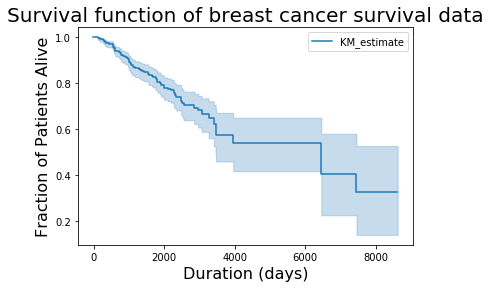

In [411]:
'''We can start performing survival analysis. We can use the Kaplan-Meier Estimate from the liflines module.
We can also find the cumulative density function of our dataset based on the two important genes.'''

#Let's make a Kaplan Meier Fitter Survival curve for the entire data set
T = df3['duration'] #we store the duration information in the dataframe T
E = df3['vital_status'] #we store the vital_status information in the dataframe E

#We will pass these dataframes to the Kaplan-Meier Estimate fitter
from lifelines import KaplanMeierFitter
from matplotlib import pyplot as plt
kmf = KaplanMeierFitter()
kmf.fit(T, event_observed=E)  
kmf.survival_function_
kmf.median_
kmf.plot()
plt.title('Survival function of breast cancer survival data', fontsize=20)
plt.xlabel('Duration (days)', fontsize=16)
plt.ylabel('Fraction of Patients Alive', fontsize=16)

Text(0,0.5,'Fraction of Patients Alive')

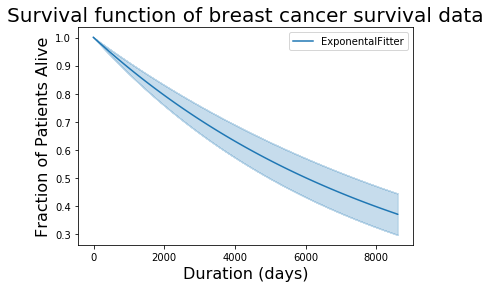

In [412]:
#We can also fit our survival curve to an exponential model. This is much smoother than the KM estimate. 
from lifelines import ExponentialFitter
exf = ExponentialFitter().fit(T, E, label='ExponentalFitter')
ax = exf.plot(ax=ax)
exf.plot()
plt.title('Survival function of breast cancer survival data', fontsize=20)
plt.xlabel('Duration (days)', fontsize=16)
plt.ylabel('Fraction of Patients Alive', fontsize=16)

Text(0,0.5,'Fraction of Patients Alive')

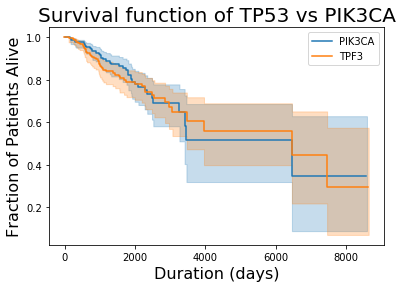

In [413]:
#Now lets plot the KMF survival curves per mutated gene. We will go ahead and plot the survival curve for each mutated gene
#and also compare them in one survival graph.
groups = df3['Hugo_Symbol'] #groups is a dataframe with the gene names

#Make the survival curve comparing TP53 gene against 
nr = (groups == 'TP53')
kmf.fit(T[~nr], E[~nr], label='PIK3CA')
ax = kmf.plot()
kmf.fit(T[nr], E[nr], label='TPF3')
ax = kmf.plot(ax=ax)
plt.title('Survival function of TP53 vs PIK3CA', fontsize=20)
plt.xlabel('Duration (days)', fontsize=16)
plt.ylabel('Fraction of Patients Alive', fontsize=16)

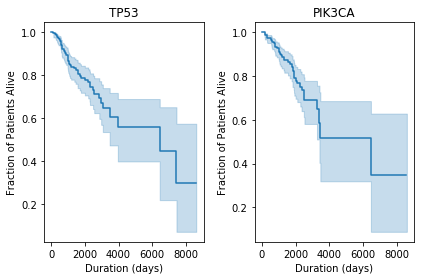

In [414]:
#We can also visualize them side by side.
mutgenes = df3['Hugo_Symbol'].unique()

for i,mg in enumerate(mutgenes):
    ax = plt.subplot(1, 2, i+1)
    ix = df3['Hugo_Symbol'] == mg
    kmf.fit( T[ix], E[ix], label=mg)
    kmf.plot(ax=ax, legend=False)
    plt.title(mg)
    if i==0:
        plt.ylabel('Fraction of Patients Alive')
        plt.xlabel("Duration (days)")
    elif i==1:
        plt.ylabel('Fraction of Patients Alive')
        plt.xlabel("Duration (days)")
plt.tight_layout()

Text(0.5,1,'Cumulative Density Function')

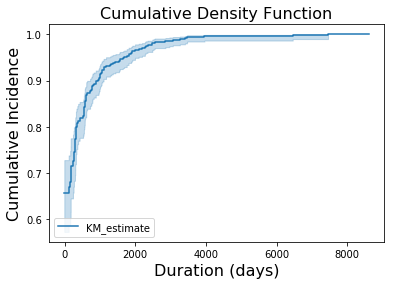

In [419]:
#Now let us plot the cumulative density function for our data set. This is the hazard function of our dataset,
#displaying the hazard of death as time goes on. We don't witness the onset of the cancer, we only know how long
#the patient has been alive or dead, so this is a good estimate of the hazard.
kmf = KaplanMeierFitter()
kmf.fit(T, E, left_censorship=True)
kmf.plot() #will plot the CDF
plt.xlabel("Duration (days)", fontsize=16)
plt.ylabel('Cumulative Incidence', fontsize=16)
plt.title("Cumulative Density Function", fontsize=16)

Text(0.5,1,'Cumulative Density Function')

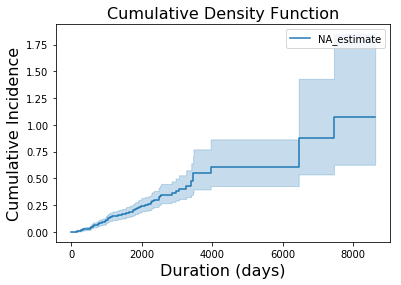

In [420]:
#There also exists another method of determining the hazard function, but it's not as appropiate for our data set since
#we don't know the onset of the cancer. This is the NelsonAalenFitter cumulative hazard function. As time goes on, the rate of 
#of change of the hazard decreases. 
from lifelines import NelsonAalenFitter
naf = NelsonAalenFitter()
naf.fit(T,event_observed=E)
naf.plot()
plt.xlabel("Duration (days)", fontsize=16)
plt.ylabel('Cumulative Incidence', fontsize=16)
plt.title("Cumulative Density Function", fontsize=16)

In [333]:
#Let's peform a logrank test to see if the death event of each generation are significantly different or not
from lifelines.statistics import multivariate_logrank_test
results = multivariate_logrank_test(df3['duration'], df3['Hugo_Symbol'], df3['vital_status'])
results.print_summary()
print("As you can see, the p-value is very high, signfying that there exists no statistical difference between the survival rates of patients with either mutation")


t_0=-1, alpha=0.95, null_distribution=chi squared, df=1

test_statistic      p   
        0.3067 0.5797
---
Signif. codes: 0 '***' 0.0001 '**' 0.001 '*' 0.01 '.' 0.05 ' ' 1
As you can see, the p-value is very high, signfying that there exists no statistical difference between the survival rates of patients with either mutation


In [421]:
'''In this section, we apply a COX regression model to see if there is an assocation with survival
time of patients and their mutated gene.'''

#COX Regression Analysis
from lifelines import CoxPHFitter
df4 = df3[['Entrez_Gene_Id', 'duration', 'vital_status']]
cph = CoxPHFitter()
cph.fit(df4, duration_col='duration', event_col='vital_status', show_progress=True)

cph.print_summary()  #results


Iteration 1: norm_delta = 0.05343, step_size = 0.95000, ll = -516.22108, newton_decrement = 0.15024, seconds_since_start = 0.0
Iteration 2: norm_delta = 0.00280, step_size = 0.95000, ll = -516.07104, newton_decrement = 0.00041, seconds_since_start = 0.0
Iteration 3: norm_delta = 0.00014, step_size = 0.95000, ll = -516.07063, newton_decrement = 0.00000, seconds_since_start = 0.0
Convergence completed after 3 iterations.
<lifelines.CoxPHFitter: fitted with 683 observations, 587 censored>
      duration col = duration
         event col = vital_status
number of subjects = 683
  number of events = 96
    log-likelihood = -516.071
  time fit was run = 2018-12-18 03:35:35 UTC

---
                 coef  exp(coef)  se(coef)      z      p  lower 0.95  upper 0.95   
Entrez_Gene_Id 0.0001     1.0001    0.0001 0.5478 0.5838     -0.0002      0.0003   
---
Signif. codes: 0 '***' 0.0001 '**' 0.001 '*' 0.01 '.' 0.05 ' ' 1

Concordance = 0.531
Likelihood ratio test = 0.301 on 1 df, p=0.58331


As can be seen, the p value is really high. The concordance is also close to .5. This means that regardless of the TP53 gene or the PIK3CA genem you have generally a 50/50 chance of determining the survival status of the patient. 

In [335]:
'''MACHINE LEARNING - In this section, we will use a gradient boosted model (xgboost) to see if you we can accurately determine
if a patient will survive their breast cancer based on their mutation status.'''

#First, we will specify our training and testing sets for our independent and dependent variables. Here the independent variable
#is the gene. We use the Entrez_Gene_Id because it an integer. The dependent variable is the vital_status of the patient.
X = df3[['Entrez_Gene_Id']]
y = df3[['vital_status']]
y=y.astype('int')

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [246]:
#Here, we apply the gradient boosted model
import xgboost as xgb
# for xgboost python API, we will need to first create a data class named `xgboost.DMatrix`
data = xgb.DMatrix(data=X_train, label=y_train)
xgb_params = {
    "eta": 0.1,
    "subsample": 0.5,
    "colsample_bytree": 0.75,
    "max_depth": 6,
    "objective": "binary:logistic",
    "eval_metric": "logloss",
    "early_stopping_rounds": 10,
    "seed": 4060
}

#Let's train our data set
xgbmodel = xgb.train(params=xgb_params, dtrain=data, num_boost_round=100)
cv_history = xgb.cv(params=xgb_params, dtrain=data, num_boost_round=100, nfold=5,
                    callbacks=[xgb.callback.print_evaluation(show_stdv=False),
                               xgb.callback.early_stop(10)])

[16:51:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[16:51:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[16:51:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[16:51:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[16:51:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[16:51:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[16:51:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 

[16:51:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[16:51:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[16:51:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[16:51:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[16:51:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[0]	train-logloss:0.643834	test-logloss:0.643939
Multiple eval metrics have been passed: 'test-logloss' will be used for early stopping.

Will train until test-logloss hasn't improved in 10 rounds.
[16:51:25] C:\Users\Administrator\Desktop\xgboost\sr

[16:51:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[16:51:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[16:51:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[16:51:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[16:51:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[11]	train-logloss:0.431097	test-logloss:0.432867
[16:51:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[16:51:25] C:\Users\Administrator\Desktop\xgboost\

[16:51:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[16:51:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:51:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:51:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:51:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[22]	train-logloss:0.398042	test-logloss:0.400952
[16:51:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[16:51:25] C:\Users\Administrator\Desktop\xgboost\

[16:51:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:51:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:51:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:51:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:51:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[33]	train-logloss:0.393128	test-logloss:0.39666
[16:51:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:51:25] C:\Users\Administrator\Desktop\xgboost\s

[16:51:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:51:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[16:51:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:51:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[16:51:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[44]	train-logloss:0.392289	test-logloss:0.395711
[16:51:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:51:25] C:\Users\Administrator\Desktop\xgboost\

Stopping. Best iteration:
[44]	train-logloss:0.392289+0.0117282	test-logloss:0.395711+0.0454091



In [247]:
#Let's take the best iteration
best_iter = cv_history["test-logloss-mean"].idxmin()
best_iter

44

In [248]:
#Let's retrain based on the best iteration
xgbmodel = xgb.train(params=xgb_params, dtrain=data, num_boost_round=best_iter)

[16:51:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[16:51:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[16:51:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[16:51:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[16:51:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[16:51:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[16:51:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 

In [249]:
#We can see each tree here.
xgbmodel.get_dump()

['0:leaf=-0.14054054\n',
 '0:leaf=-0.125538617\n',
 '0:leaf=-0.12289609\n',
 '0:leaf=-0.10902641\n',
 '0:leaf=-0.108577408\n',
 '0:leaf=-0.0949041918\n',
 '0:[Entrez_Gene_Id<6224] yes=1,no=2,missing=1\n\t1:leaf=-0.0895687342\n\t2:leaf=-0.0561792962\n',
 '0:leaf=-0.0856757537\n',
 '0:leaf=-0.0757979974\n',
 '0:leaf=-0.0672403723\n',
 '0:leaf=-0.0609164238\n',
 '0:leaf=-0.0715339035\n',
 '0:leaf=-0.0647048876\n',
 '0:[Entrez_Gene_Id<6224] yes=1,no=2,missing=1\n\t1:leaf=-0.0644061416\n\t2:leaf=-0.0287770461\n',
 '0:leaf=-0.0639671385\n',
 '0:[Entrez_Gene_Id<6224] yes=1,no=2,missing=1\n\t1:leaf=-0.0407248847\n\t2:leaf=-0.058932703\n',
 '0:[Entrez_Gene_Id<6224] yes=1,no=2,missing=1\n\t1:leaf=-0.0688776001\n\t2:leaf=-0.0448511057\n',
 '0:[Entrez_Gene_Id<6224] yes=1,no=2,missing=1\n\t1:leaf=-0.033858262\n\t2:leaf=-0.0211233944\n',
 '0:[Entrez_Gene_Id<6224] yes=1,no=2,missing=1\n\t1:leaf=-0.0437113158\n\t2:leaf=-0.0285362955\n',
 '0:[Entrez_Gene_Id<6224] yes=1,no=2,missing=1\n\t1:leaf=-0.05407

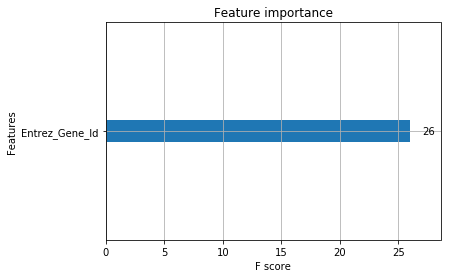

In [250]:
#We can plot the F score of our genes
xgb.plot_importance(xgbmodel)

In [251]:
#Let's do a prediction
y_test_pred = xgbmodel.predict(xgb.DMatrix(X_test))
# Generate class prediction based on max probability
y_test_pred_class = y_test_pred.argmax(axis=0)
y_test_pred_class

0

In [252]:
#Accuracy of our prediction
print("Accuracy with GBM: ")
(y_test_pred_class == y_test).mean()

Accuracy with GBM: 


vital_status    0.845133
dtype: float64

As we can see, using the graident boosting model, we were able to predict the vital status of our patient with an accuracy of 85%. This means we can correctly say if a patient will survive or not based on their mutated gene 85% of the time. This is more than what was accomplished by Cheng et al. However, we only use two important genes and an limited data set. We can improve this accuracy and importance with more biomarking genes and a greater amount of data points. 


In [382]:
#Below, I went ahead and used the gradient boosting model again, but I also set the objective to binary:hinge. This parameter
#makes predictions of 0 or 1 rather than a probability. The result was ultimatly similar at 85% accuracy.
X = df3[['Entrez_Gene_Id']]
y = df3[['vital_status']]
y=y.astype('int')

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)


In [390]:
#Here, we apply the gradient boosted model
import xgboost as xgb
# for xgboost python API, we will need to first create a data class named `xgboost.DMatrix`
data = xgb.DMatrix(data=X_train, label=y_train)
xgb_params = {
    "eta": 0.1,
    "subsample": 0.5,
    "colsample_bytree": 0.75,
    "max_depth": 6,
    "objective": "binary:hinge",
    "eval_metric": "logloss",
    "early_stopping_rounds": 10,
    "seed": 4060
}

#Let's train our data set
xgbmodel = xgb.train(params=xgb_params, dtrain=data, num_boost_round=1000)
cv_history = xgb.cv(params=xgb_params, dtrain=data, num_boost_round=1000, nfold=5,
                    callbacks=[xgb.callback.print_evaluation(show_stdv=False),
                               xgb.callback.early_stop(10)])

[18:58:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[18:58:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[18:58:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[18:58:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[18:58:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[18:58:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[18:58:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 

[18:58:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[18:58:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[18:58:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[18:58:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[18:58:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[18:58:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[18:58:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 

[18:58:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[18:58:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[18:58:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[18:58:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[18:58:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[18:58:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[18:58:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 

[18:58:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[18:58:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[18:58:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[18:58:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[18:58:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[18:58:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[18:58:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 

[18:58:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[18:58:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[18:58:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[18:58:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[18:58:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[18:58:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[18:58:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 

[18:58:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[18:58:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[18:58:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[18:58:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[18:58:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[10]	train-logloss:4.9177	test-logloss:4.91981
[18:58:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[18:58:16] C:\Users\Administrator\Desktop\xgboost\src

In [391]:
#Let's take the best iteration
best_iter = cv_history["test-logloss-mean"].idxmin()
best_iter

7

In [392]:
#Let's retrain based on the best iteration
xgbmodel = xgb.train(params=xgb_params, dtrain=data, num_boost_round=best_iter)

[18:58:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[18:58:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[18:58:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[18:58:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[18:58:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[18:58:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[18:58:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 

In [393]:
#We can see each tree here.
xgbmodel.get_dump()

['0:leaf=-0.0712328777\n',
 '0:leaf=-0.0702586249\n',
 '0:leaf=-0.0743478239\n',
 '0:[Entrez_Gene_Id<6224] yes=1,no=2,missing=1\n\t1:leaf=-0.0785714313\n\t2:leaf=-0.0649572685\n',
 '0:leaf=-0.0760504231\n',
 '0:leaf=-0.0733031705\n',
 '0:[Entrez_Gene_Id<6224] yes=1,no=2,missing=1\n\t1:leaf=-0.0743362829\n\t2:leaf=-0.0590909086\n']

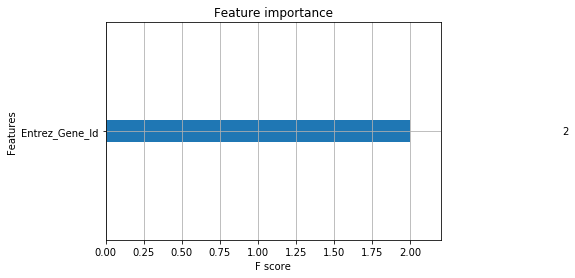

In [394]:
#We can plot the F score of our genes
xgb.plot_importance(xgbmodel)

In [395]:
#Let's do a prediction
y_test_pred = xgbmodel.predict(xgb.DMatrix(X_test))
# Generate class prediction based on max probability
y_test_pred_class = y_test_pred.argmax(axis=0)
y_test_pred_class

0

In [396]:
#Accuracy of our prediction
print("Accuracy with GBM: ")
(y_test_pred_class == y_test).mean()

Accuracy with GBM: 


vital_status    0.845133
dtype: float64

As we can see with the different objective, we get the same result, even though we recieved fewer trees this time around. Thus, our model is very good at determining survival status of patients based on their mutation. 